# **Agriculture Vision (Image Anomaly Classification) - Base Model**



#**1.   Download Dataset**


---




In [0]:
# Download the Dataset from Google Drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CLaSc58acJOILjBpUemNvy-6WXCd3llz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CLaSc58acJOILjBpUemNvy-6WXCd3llz" -O "Agri-vision.zip" && rm -rf /tmp/cookies.txt



#**2.   Unzip the Dataset**



---



In [0]:
# Unzip the Dataset
!unzip Agri-vision.zip



#**3.   Import Libraries**


---




In [0]:
# Import all the required Libraries

# Load the TensorBoard notebook extension
%load_ext tensorboard

from google.colab import files
from google.colab import drive
from PIL import Image
from IPython.display import display
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import shutil
import math
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard




#**4.   Define Label Dictionary**



---



In [0]:
# The Dictionary is just for reference, to view how the labels are represented
ref = {1:'cloud_shadow',
       2:'double_plant',
       3:'planter_skip',
       4:'standing_water',
       5:'waterway',
       6:'weed_cluster'
      }



#**5.   References to all required directories**



---



In [0]:
# References to all required directories

root='/content'

# Training
train_images_dir = os.path.join(root,'Agriculture-Vision/train/images/')
train_label_cloud_shadow_dir = os.path.join(root,'Agriculture-Vision/train/labels/cloud_shadow/')
train_label_double_plant_dir = os.path.join(root,'Agriculture-Vision/train/labels/double_plant/')
train_label_planter_skip_dir = os.path.join(root,'Agriculture-Vision/train/labels/planter_skip/')
train_label_standing_water_dir = os.path.join(root,'Agriculture-Vision/train/labels/standing_water/')
train_label_water_way_dir = os.path.join(root,'Agriculture-Vision/train/labels/waterway/')
train_label_weed_cluster_dir = os.path.join(root,'Agriculture-Vision/train/labels/weed_cluster/')
train_image_rgb_dir = os.path.join(root,'Agriculture-Vision/train/images/rgb/')
train_image_nir_dir= os.path.join(root,'Agriculture-Vision/train/images/nir/')
train_boundaries_dir= os.path.join(root,'Agriculture-Vision/train/boundaries/')
train_mask_dir= os.path.join(root,'Agriculture-Vision/train/masks/')
train_labels_dirs_list = [train_label_cloud_shadow_dir,train_label_double_plant_dir,
                          train_label_planter_skip_dir,train_label_standing_water_dir,
                          train_label_water_way_dir,train_label_weed_cluster_dir]

# Validation
val_images_dir = os.path.join(root,'Agriculture-Vision/val/images/')
val_label_cloud_shadow_dir = os.path.join(root,'Agriculture-Vision/val/labels/cloud_shadow/')
val_label_double_plant_dir = os.path.join(root,'Agriculture-Vision/val/labels/double_plant/')
val_label_planter_skip_dir = os.path.join(root,'Agriculture-Vision/val/labels/planter_skip/')
val_label_standing_water_dir = os.path.join(root,'Agriculture-Vision/val/labels/standing_water/')
val_label_water_way_dir = os.path.join(root,'Agriculture-Vision/val/labels/waterway/')
val_label_weed_cluster_dir = os.path.join(root,'Agriculture-Vision/val/labels/weed_cluster/')
val_image_rgb_dir = os.path.join(root,'Agriculture-Vision/val/images/rgb/')
val_image_nir_dir= os.path.join(root,'Agriculture-Vision/val/images/nir/')
val_boundaries_dir= os.path.join(root,'Agriculture-Vision/val/boundaries/')
val_mask_dir= os.path.join(root,'Agriculture-Vision/val/masks/')
val_labels_dirs_list = [val_label_cloud_shadow_dir,val_label_double_plant_dir,
                        val_label_planter_skip_dir, val_label_standing_water_dir,
                        val_label_water_way_dir,val_label_weed_cluster_dir]

# Testing
test_images_dir = os.path.join(root,'Agriculture-Vision/test/images/')
test_image_rgb_dir = os.path.join(root,'Agriculture-Vision/test/images/rgb/')
test_image_nir_dir= os.path.join(root,'Agriculture-Vision/test/images/nir/')
test_boundaries_dir= os.path.join(root,'Agriculture-Vision/test/boundaries/')
test_mask_dir= os.path.join(root,'Agriculture-Vision/test/masks/')

# For future global reference
train_list_label_file_names=[]
train_label_list=[]
val_list_label_file_names=[] 
val_label_list=[]
test_file_names=[]
model_ip_type=[]
log_folder=[]



#**6.   Number of Input Images**



---



In [0]:
print(len(os.listdir(train_label_cloud_shadow_dir)))

12901


#**7.   Function - Label Creation**



---

In [0]:
# Label Creation
def CreateLabels(list_label_dirs):
  name= ' Training' if 'train' in list_label_dirs[0] else ' Validation'
  list_of_label_file_names = os.listdir(list_label_dirs[0])
  label_list=[]
  for i in list_of_label_file_names:

    # load the image
    cloud_shadow_image = Image.open(list_label_dirs[0]+i)
    double_plant_image = Image.open(list_label_dirs[1]+i)
    planter_skip_image = Image.open(list_label_dirs[2]+i)
    standing_water_image = Image.open(list_label_dirs[3]+i)
    water_way_image = Image.open(list_label_dirs[4]+i)
    weed_cluster_image = Image.open(list_label_dirs[5]+i)

    # convert image to numpy array
    cloud_shadow_imagedata = asarray(cloud_shadow_image)
    double_plant_imagedata = asarray(double_plant_image)
    planter_skip_imagedata = asarray(planter_skip_image)
    standing_water_imagedata = asarray(standing_water_image)
    water_way_imagedata = asarray(water_way_image)
    weed_cluster_imagedata = asarray(weed_cluster_image)

    #sum of numpy array
    csid = sum(sum(abs(cloud_shadow_imagedata)))
    dpid = sum(sum(abs(double_plant_imagedata)))
    psid = sum(sum(abs(planter_skip_imagedata)))
    swid = sum(sum(abs(standing_water_imagedata)))
    wwid = sum(sum(abs(water_way_imagedata)))
    wcid = sum(sum(abs(weed_cluster_imagedata)))

    labels = {1:csid, 2:dpid, 3:psid, 4:swid, 5:wwid, 6:wcid}
    label = max(labels, key=labels.get)
    #label_list.append((i.replace('.png',''),label))
    label_list.append(label)
  print('Generated '+str(len(label_list))+name+' Labels!')
  print(CreateLabels.__name__,' Executed!\n')
  return list_of_label_file_names, label_list


#**8.   Function - Create Directories for Masked Images**



---

In [0]:
# Create directories for masked images
def CreateMaskImgDirs(dir, length):
  name='' 
  if 'train' in dir:
    name='Training'
  elif 'val' in dir:
    name='Validation'
  else: name='Testing'
  typeim = 'NIR' if 'nir' in dir else 'RGB'
  os.mkdir(dir)
  if name!='Testing':
    for i in range(1,length+1):
        os.mkdir(os.path.join(dir,str(i)))
  print('Generated '+name+' Masked '+typeim+' Image Directory!')
  print(CreateMaskImgDirs.__name__,' Executed!\n')

#**9.   Function - Generate Masked Images and Store them in Directory**



---

In [0]:
# Generate masked images and store them in directory
def MaskImages(dest_dir, label_list, list_of_labels,input_dir,mask_dir,boundaries_dir):
  name='' 
  if 'train' in dest_dir:
    name='Training'
  elif 'val' in dest_dir:
    name='Validation'
  else: name='Testing'
  typeim = 'NIR' if 'nir' in dest_dir else 'RGB'
  for i,image_name in enumerate(list_of_labels):
      if name!='Testing': image_name = image_name.replace('.png','')
      else: image_name = image_name.replace('.jpg','')
      image=Image.open(os.path.join(input_dir,image_name)+'.jpg')
      mask_m=Image.open(os.path.join(mask_dir,image_name)+'.png')
      mask_b=Image.open(os.path.join(boundaries_dir,image_name)+'.png')
      image=cv2.bitwise_and(np.array(image),np.array(image),mask=np.array(mask_m))
      image=cv2.bitwise_and(np.array(image),np.array(image),mask=np.array(mask_b))
      image_path=''
      try:
        if name!='Testing':
          image_path=dest_dir+"/"+str(label_list[i])+"/"+image_name+".jpg"
        else: image_path=dest_dir+"/"+image_name+".jpg"
      except Exception as e:
        print(e)
      try:
       cv2.imwrite(image_path,image)
      except Exception as e:
        print(e)
  print('Generated '+str(len(list_of_labels))+' '+name+' Masked '+typeim+' Images!')
  print(MaskImages.__name__,' Executed!\n')

#**10.   Function - Image Preprocessing - Call to Sub Functions**

> Indented block

> Indented block







---

In [0]:
def DataPreprocessing():

  if (not train_list_label_file_names) and (not train_label_list):
    train_fn_lb= CreateLabels(train_labels_dirs_list)
    train_list_label_file_names.extend(train_fn_lb[0])
    train_label_list.extend(train_fn_lb[1])

  if (not val_list_label_file_names) and (not val_label_list):
    val_fn_lb= CreateLabels(val_labels_dirs_list)
    val_list_label_file_names.extend(val_fn_lb[0])
    val_label_list.extend(val_fn_lb[1])
    
  # Training/Validation Masked NIR Images/Directories
  path_train_nir = os.path.join(train_images_dir,'masked_images_nir')
  path_val_nir = os.path.join(val_images_dir,'masked_images_nir')
  if not os.path.isdir(path_train_nir):
    CreateMaskImgDirs(path_train_nir,len(train_labels_dirs_list))
    MaskImages(path_train_nir, train_label_list, train_list_label_file_names, train_image_nir_dir, 
            train_mask_dir, train_boundaries_dir)
  if not os.path.isdir(path_val_nir):
    CreateMaskImgDirs(path_val_nir,len(val_labels_dirs_list))
    MaskImages(path_val_nir, val_label_list, val_list_label_file_names, val_image_nir_dir, 
              val_mask_dir, val_boundaries_dir)

  # Training/Validation Masked RGB Images/Directories
  path_train_rgb = os.path.join(train_images_dir,'masked_images_rgb')
  path_val_rgb = os.path.join(val_images_dir,'masked_images_rgb')
  if not os.path.isdir(path_train_rgb):
    CreateMaskImgDirs(path_train_rgb,len(train_labels_dirs_list))
    MaskImages(path_train_rgb, train_label_list, train_list_label_file_names, train_image_rgb_dir, 
            train_mask_dir, train_boundaries_dir)
  if not os.path.isdir(path_val_rgb):
    CreateMaskImgDirs(path_val_rgb,len(val_labels_dirs_list))
    MaskImages(path_val_rgb, val_label_list, val_list_label_file_names, val_image_rgb_dir, 
              val_mask_dir, val_boundaries_dir)
    
  # Testing Masked NIR Images/Directories
  path_test_nir = os.path.join(test_images_dir,'masked_images_nir')
  if not test_file_names:
    test_file_names.extend(os.listdir(test_image_nir_dir))
  if not os.path.isdir(path_test_nir) :
    CreateMaskImgDirs(path_test_nir,len(train_labels_dirs_list))
    MaskImages(path_test_nir, train_label_list, test_file_names, test_image_nir_dir, 
            test_mask_dir, test_boundaries_dir)
    
  # Testing Masked RGB Images/Directories
  path_test_rgb = os.path.join(test_images_dir,'masked_images_rgb')
  if not os.path.isdir(path_test_rgb):
    CreateMaskImgDirs(path_test_rgb,len(train_labels_dirs_list))
    MaskImages(path_test_rgb, train_label_list, test_file_names, test_image_rgb_dir, 
            test_mask_dir, test_boundaries_dir)
    
  return path_train_nir, path_val_nir, path_train_rgb, path_val_rgb, path_test_nir, path_test_rgb


#**11.   Function - Image Data Genrator**



---

In [0]:
# Image Data Genrator
def ImageDataGenProcess(training_directory, validation_directory, cmode, batch_size, height, width):
  training_data_generator = ImageDataGenerator(rescale=1./255)
  train_generator = training_data_generator.flow_from_directory(training_directory,
                                                                color_mode=cmode,
                                                                batch_size=batch_size,
                                                                target_size=(height,width))

  val_data_generator = ImageDataGenerator(rescale=1./255)
  val_generator = val_data_generator.flow_from_directory(validation_directory,
                                                         color_mode=cmode,
                                                         batch_size=batch_size,
                                                         target_size=(height,width))
  print(ImageDataGenProcess.__name__,' Executed!\n')
  return train_generator, val_generator

#**12.   Function - Base Model**



---

In [0]:
# Model
def BaseModelDefinition(height, width, channel):
  model=Sequential()
  model.add(Conv2D(64,(3,3),activation='relu',input_shape=(height, width, channel)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(512,activation='relu', activity_regularizer=regularizers.l2(0.001)))
  model.add(Dense(256,activation='tanh'))
  model.add(Dense(6,activation='softmax'))

  model.summary()

  print(BaseModelDefinition.__name__,' Executed!\n')
  return model

#**13.   Function - Compile Fit**



---

In [0]:
# Fit the model and complie the model
def CompileFit(model, train_generator, val_generator, batch_size, num_train_samples, num_val_samples):
  	# patient early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                metrics=['accuracy'])
  if log_folder:
    log_folder.pop()
    log_folder.append(model_ip_type[0] + "_logs")
  else:
    log_folder.append(model_ip_type[0] + "_logs")
  logdir = os.path.join(root,log_folder[0], datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = TensorBoard(logdir, 
                           histogram_freq=1, 
                           batch_size=batch_size, 
                           write_graph=True, 
                           write_grads=True, 
                           write_images=True, 
                           update_freq='epoch')
  
  model.fit_generator(train_generator,
                      steps_per_epoch=math.ceil(num_train_samples / batch_size),
                      epochs=75,
                      validation_data=val_generator,
                      validation_steps=math.ceil(num_val_samples / batch_size),
                      callbacks=[tensorboard_callback, es])
  
  print(CompileFit.__name__,' Executed!\n')
  return model

#**14.   Function - Plot Model Performance**



---

In [0]:
# Plot the model performace
def PlotPerformance(model):

  loss = model.history.history['loss']
  accuracy = model.history.history['accuracy']
  val_loss = model.history.history['val_loss']
  val_accuracy = model.history.history['val_accuracy']

  plt.figure(figsize=(7,7))
  plt.plot(np.arange(1,len(loss)+1),loss,label="Loss")
  plt.plot(np.arange(1,len(val_loss)+1),val_loss,label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Vs Val Loss per Epoch")
  plt.legend()
  plt.show()

  plt.figure(figsize=(7,7))
  plt.plot(np.arange(1,len(accuracy)+1),accuracy,label="Accuracy")
  plt.plot(np.arange(1,len(val_accuracy)+1),val_accuracy,label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Val Accuracy per Epoch")
  plt.legend()
  plt.show()

  print(PlotPerformance.__name__,' Executed!\n')

#**15.   Function - Call to Base Model**



---

In [0]:
# Run the Base Model
def BaseModel(path_train, path_val, color_mode, batch_size, channel, height, width):

  train_generator, val_generator = ImageDataGenProcess(path_train, path_val, color_mode, batch_size, height, width)

  model = BaseModelDefinition(height, width, channel)

  len_train_dataset=len(train_list_label_file_names)
  len_val_dataset=len(val_list_label_file_names)
  model = CompileFit(model, train_generator, val_generator, batch_size, len_train_dataset, len_val_dataset)

  print(BaseModel.__name__,' Executed!\n')
  return model
  

#**16.   Function - Main Method - Call to Sub Functions**



---

/content/Agriculture-Vision/train/images/masked_images_nir
/content/Agriculture-Vision/val/images/masked_images_nir
grayscale
80
1
150
150
base_agriculture_vision_nir_masked.h5
Found 12901 images belonging to 6 classes.
Found 4431 images belonging to 6 classes.
ImageDataGenProcess  Executed!

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)     

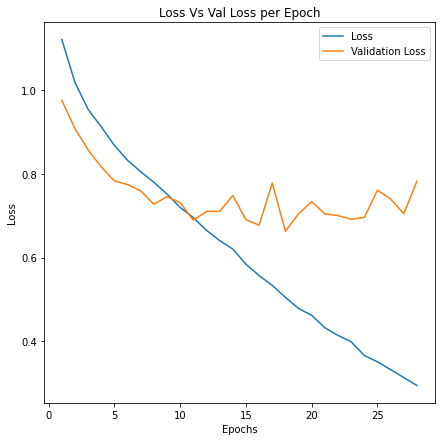

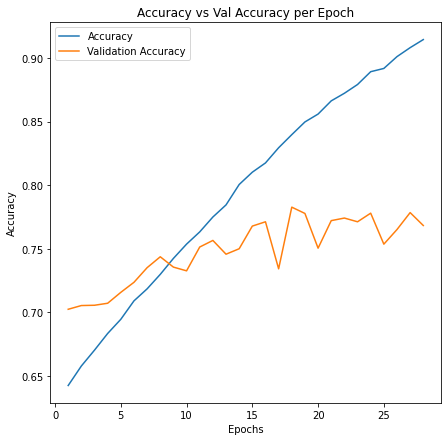

PlotPerformance  Executed!



In [0]:
# Main Function
def main(training_path ='', validation_path ='', color_mode = '', batch_size=0, 
         channel=0, height=0, width=0, model_save_path=''):
    
    result = DataPreprocessing()
    path_train_nir = result[0]
    path_val_nir = result[1]
    path_train_rgb = result[2]
    path_val_rgb = result[3]
    path_test_nir = result[4]
    path_test_rgb = result[5]  

    BaseModelInputType=2 # 1: Masked RGB Input Images # 2: Maked NIR Input Images
    
    if BaseModelInputType==1:
      # Base Model Input Parameters with Masked RGB Images
      if model_ip_type:
        model_ip_type.pop()
        model_ip_type.append('rgb')
      else:
        model_ip_type.append('rgb')
      training_path = path_train_rgb
      validation_path = path_val_rgb
      color_mode = "rgb"
      batch_size = 80
      channel = 3
      height = 150
      width = 150
      model_save_path =  "base_agriculture_vision_rgb_masked.h5"
    elif BaseModelInputType==2:
      # Base Model Input Parameters with Masked NIR Images
      if model_ip_type:
        model_ip_type.pop()
        model_ip_type.append('nir')
      else:
        model_ip_type.append('nir')
      training_path = path_train_nir
      validation_path = path_val_nir
      color_mode = "grayscale"
      batch_size = 80
      channel = 1
      height = 150
      width = 150
      model_save_path =  "base_agriculture_vision_nir_masked.h5"
    
    # Train the Base Model
    print(training_path)
    print(validation_path)
    print(color_mode)
    print(batch_size)
    print(channel)
    print(height)
    print(width)
    print(model_save_path)
    model = BaseModel(training_path, validation_path, color_mode, batch_size, channel, height, width)
    model.save(model_save_path)

    # Plot the model performance
    PlotPerformance(model)

    # Predict test images
    #PredictTest(model, path_test_nir, path_test_rgb, height)

if __name__ == '__main__':
    main()

#**17.   Predict Images**



---

(None, 150, 150, 1)
(150, 150)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


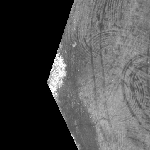

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'> (150, 150, 1)
<class 'numpy.ndarray'> (1, 150, 150, 1)
Class: 5 [waterway]



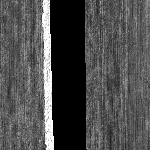

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'> (150, 150, 1)
<class 'numpy.ndarray'> (1, 150, 150, 1)
Class: 6 [weed_cluster]



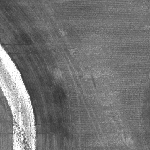

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'> (150, 150, 1)
<class 'numpy.ndarray'> (1, 150, 150, 1)
Class: 6 [weed_cluster]



In [0]:
# Predict Test Images
import random

# Select Predict_Image_Type=1 for NIR Images
# Select Predict_Image_Type=2 for RGB Images
Predict_Image_Type=1


val=''
if Predict_Image_Type==1:
  val='nir'
elif Predict_Image_Type==2:
  val='rgb'

contents=os.listdir(root)
model_save_path=''
for filen in contents:
  if filen.endswith('.h5') and val in filen:
    model_save_path=filen

model = load_model(model_save_path)

# check the input format
print(model.input_shape)
dims = model.input_shape[1:3] # -> (height, width)
print(dims)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

im_dir = test_images_dir + 'masked_images_' + val
filename_lst=os.listdir(im_dir)
indexes = random.sample(range(0,len(filename_lst)-1), 3)
for i,ind in enumerate(indexes):
  ims_path = os.path.join(im_dir,filename_lst[ind])
  if val!='rgb':
    ims = image.load_img(ims_path, color_mode='grayscale', grayscale=True,target_size=dims)
  else:
    ims = image.load_img(ims_path, target_size=dims)
  display(ims)
  print(type(ims))
  
  doc = image.img_to_array(ims) # -> numpy array
  print(type(doc), doc.shape)

  doc = np.expand_dims(doc, axis=0)
  print(type(doc), doc.shape)

  predictions = model.predict(doc)

  predicted_class_indices=np.argmax(predictions,axis=1)+1
  print('Class: '+str(predicted_class_indices[0])+' '+'['+ref[predicted_class_indices[0]]+']\n')




#**18.   Tensorboard - To Assess Model Performance**



---

In [0]:
%tensorboard --logdir nir_logs
#%tensorboard --logdir rgb_logs


#**19.   Download ZIP to Google Drive (Model and Model Weights)**



---

In [0]:
# Download Model and Model Weigths to Google Drive


# Select Download_Model=1 where input is NIR Images
# Select Download_Model=2 where input is RGB Images
Download_Model=1


val=''
if Download_Model==1:
  val='nir'
elif Download_Model==2:
  val='rgb'


contents=os.listdir(root)
model_save_path=''
for filen in contents:
  if filen.endswith('.h5') and val in filen:
    model_save_path=filen

sv=val+'_base_model_details'
svdir='/content/'+sv

shutil.copytree("/content/"+log_folder[0], svdir)
shutil.copyfile("/content/"+model_save_path, svdir+'/'+model_save_path)

if val=='nir':
  #For the folder you have to zip it first and can only download later on
  !zip -r nir_base_model_details.zip /content/nir_logs
  #Download zip file to Google Drive
  drive.mount('/content/gdrive',force_remount=True)
  !cp nir_base_model_details.zip '/content/gdrive/My Drive/Capstone/'
elif val=='rgb':
  #For the folder you have to zip it first and can only download later on
  !zip -r rgb_base_model_details.zip /content/rgb_logs
  #Download zip file to Google Drive
  drive.mount('/content/gdrive',force_remount=True)
  !cp rgb_base_model_details.zip '/content/gdrive/My Drive/Capstone/'
!ls -lt '/content/gdrive/My Drive/Capstone/'

  adding: content/nir_logs/ (stored 0%)
  adding: content/nir_logs/20200430-201823/ (stored 0%)
  adding: content/nir_logs/20200430-201823/validation/ (stored 0%)
  adding: content/nir_logs/20200430-201823/validation/events.out.tfevents.1588277978.2c022faea8f9.123.2245.v2 (deflated 62%)
  adding: content/nir_logs/20200430-201823/train/ (stored 0%)
  adding: content/nir_logs/20200430-201823/train/events.out.tfevents.1588277911.2c022faea8f9.profile-empty (deflated 5%)
  adding: content/nir_logs/20200430-201823/train/events.out.tfevents.1588277904.2c022faea8f9.123.205.v2 (deflated 0%)
  adding: content/nir_logs/20200430-201823/train/plugins/ (stored 0%)
  adding: content/nir_logs/20200430-201823/train/plugins/profile/ (stored 0%)
  adding: content/nir_logs/20200430-201823/train/plugins/profile/2020_04_30_20_18_31/ (stored 0%)
  adding: content/nir_logs/20200430-201823/train/plugins/profile/2020_04_30_20_18_31/2c022faea8f9.overview_page.pb (deflated 56%)
  adding: content/nir_logs/20200430

#**20.   Delete Section - Delete Directories and Files**



---

In [0]:
#Delete Training Masked Nir Image Directory
train_dir_path = train_images_dir + 'masked_images_nir'
try:
    shutil.rmtree(train_dir_path)
except OSError as e:
    print("Error: %s : %s" % (train_dir_path, e.strerror))


Error: /content/Agriculture-Vision/val/images/masked_images_nir : No such file or directory


In [0]:
#Delete Validation Masked Nir Image Directory
val_dir_path = val_images_dir + 'masked_images_nir'
try:
    shutil.rmtree(val_dir_path)
except OSError as e:
    print("Error: %s : %s" % (val_dir_path, e.strerror))

In [0]:
#Delete Training Masked Rgb Image Directory
train_dir_path = train_images_dir + 'masked_images_rgb'
try:
    shutil.rmtree(train_dir_path)
except OSError as e:
    print("Error: %s : %s" % (train_dir_path, e.strerror))


Error: /content/Agriculture-Vision/train/images/masked_images_rgb : No such file or directory
Error: /content/Agriculture-Vision/val/images/masked_images_rgb : No such file or directory


In [0]:
#Delete Validation Masked Rgb Image Directory
val_dir_path = val_images_dir + 'masked_images_rgb'
try:
    shutil.rmtree(val_dir_path)
except OSError as e:
    print("Error: %s : %s" % (val_dir_path, e.strerror))

In [0]:
#Delete Testing Masked Nir Image Directory
test_nir_path_del= test_images_dir + 'masked_images_nir'
try:
    shutil.rmtree(test_nir_path_del)
except OSError as e:
    print("Error: %s : %s" % (test_nir_path_del, e.strerror))

Error: /content/Agriculture-Vision/test/images/masked_images_nir : No such file or directory


In [0]:
#Delete Testing Masked RGB Image Directory
test_rgb_path_del=test_images_dir + 'masked_images_rgb'
try:
    shutil.rmtree(test_rgb_path_del)
except OSError as e:
    print("Error: %s : %s" % (test_rgb_path_del, e.strerror))

In [0]:
#Delete Generated NIR Model Log Directory
try:
    shutil.rmtree("/content/nir_logs")
except OSError as e:
    print("Error: %s : %s" % ("/content/nir_logs", e.strerror))

In [0]:
#Delete Generated RGB Model Log Directory
try:
    shutil.rmtree("/content/rgb_logs")
except OSError as e:
    print("Error: %s : %s" % ("/content/rgb_logs", e.strerror))

In [0]:
#Delete Generated NIR Model Details Directory
try:
    shutil.rmtree("/content/nir_base_model_details")
except OSError as e:
    print("Error: %s : %s" % ("/content/nir__base_model_details", e.strerror))

In [0]:
#Delete Generated RGB Model Details Directory
try:
    shutil.rmtree("/content/rgb_base_model_details")
except OSError as e:
    print("Error: %s : %s" % ("/content/rgb_base_model_details", e.strerror))